In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from geopy.geocoders import Nominatim
import folium
import re
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm

import matplotlib.colors as colors

In [2]:
latitude = 28.6141793
longitude = 77.2022662

In [3]:
delhi_neighborhood_data = pd.read_csv(r'../input/delhi-neighborhood-data/delhi_dataSet.csv')
delhi_neighborhood_data.dropna(inplace=True)
delhi_neighborhood_data.reset_index(inplace=True)
delhi_neighborhood_data.drop(['index','Unnamed: 0'], axis=1, inplace=True)
delhi_neighborhood_data.head()

,Borough,Neighborhood,latitude,longitude
0,North West Delhi,Adarsh Nagar,28.614192,77.071541
1,North West Delhi,Ashok Vihar,28.699453,77.184826
2,North West Delhi,Azadpur,28.707657,77.175547
3,North West Delhi,Bawana,28.799660,77.032885
4,North West Delhi,Dhaka,39.031714,-90.261223


### Visualing the obtained data set

In [4]:
delhiData = delhi_neighborhood_data
map_delhi = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(delhiData['latitude'], delhiData['longitude'], delhiData['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_delhi)  
    
map_delhi

In [5]:
delhi_venues = pd.read_csv(r'../input/delhi-neighborhood-data/restaurant_dataSet.csv')
delhi_venues.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Adarsh Nagar,28.614193,77.071541,Eagle Boys Pizza,28.615595,77.070784,Pizza Place
1,1,Adarsh Nagar,28.614193,77.071541,Bikanerwala,28.613391,77.076084,Indian Restaurant
2,2,Adarsh Nagar,28.614193,77.071541,Bikano East Patel Nagar,28.616190,77.066978,Fast Food Restaurant
3,3,Adarsh Nagar,28.614193,77.071541,McDonald's,28.616330,77.067034,Fast Food Restaurant
4,4,Ashok Vihar,28.699453,77.184826,Nat Khat Caterers,28.699630,77.187832,Indian Restaurant


In [6]:
map_res = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(delhi_venues['Venue Latitude'], delhi_venues['Venue Longitude'], delhi_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_res)  
    
map_res

### Summary
* We have, as a result, generated to data Sets.
* The first was the data set(delhi_data) that contained the borough, name, Latitude and Longitude of all the major Neighborhoods of Delhi
* And, the second data set(delhi_venues) contained the geographical information pertinent to all the major restaurants in delhi
<br><br>

<h2>Clustering and Analysis</h2>
<a name='analysis'></a>
<br>
Our goal here is to find the neighborhoods with low density of Indian restaurants. But, how will we decide which neighborhoods, currently operating on minimal number of Indian restaurants, have the potential for growth and which neighborhoods do not.
<br><br>
The most intuitive idea would be to find neighborhoods that have similar patterns of restaurant trends.
<br><br>
This can be achived by clustering the neighborhoods of the basis of the restaurant data we have acquired. Clustering is a predominant algorithm of unsupervised Machine Learning. It is used to segregate data entries in cluster depending of the similarity of their attributes, calculated by using the simple formula of euclidian distance.
<br><br>
We can then analyze these clusters separately and use those clusters that show high trends of Indian Restaurants

### Normalization of the data for clustering

In [7]:
# one hot encoding
delhi_onehot = pd.get_dummies(delhi_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
delhi_onehot['Neighborhood'] = delhi_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [delhi_onehot.columns[-1]] + list(delhi_onehot.columns[:-1])
delhi_onehot = delhi_onehot[fixed_columns]

delhi_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Awadhi Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Soup Place,South Indian Restaurant,Steakhouse,Sushi Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ashok Vihar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
delhi_onehot.shape

(849, 75)

In [9]:
#To be used while Generating Graphs
delhi_grouped = delhi_onehot.groupby('Neighborhood').mean().reset_index()
delhi_grouped.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Awadhi Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Soup Place,South Indian Restaurant,Steakhouse,Sushi Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,Adarsh Nagar,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alaknanda,0.0,0.0,0.00,0.0,0.0,0.0,0.222222,0.0,0.00,...,0.000000,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Anand Vihar,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00,...,0.166667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ashok Vihar,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.25,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Azadpur,0.0,0.0,0.25,0.0,0.0,0.0,0.000000,0.0,0.00,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
for i in delhi_grouped.columns:
    print(i,end=", ")

Neighborhood, Afghan Restaurant, American Restaurant, Argentinian Restaurant, Asian Restaurant, Australian Restaurant, Awadhi Restaurant, BBQ Joint, Bagel Shop, Bakery, Bengali Restaurant, Bistro, Breakfast Spot, Buffet, Burger Joint, Burmese Restaurant, Cafeteria, Café, Chinese Restaurant, Comfort Food Restaurant, Deli / Bodega, Dhaba, Dim Sum Restaurant, Diner, Doner Restaurant, Donut Shop, Dumpling Restaurant, Eastern European Restaurant, Falafel Restaurant, Fast Food Restaurant, Fish & Chips Shop, Food, Food Court, Food Stand, Food Truck, French Restaurant, Fried Chicken Joint, Gastropub, Hot Dog Joint, Hyderabadi Restaurant, Indian Chinese Restaurant, Indian Restaurant, Indian Sweet Shop, Irani Cafe, Italian Restaurant, Japanese Restaurant, Korean Restaurant, Mediterranean Restaurant, Mexican Restaurant, Middle Eastern Restaurant, Modern European Restaurant, Molecular Gastronomy Restaurant, Mughlai Restaurant, Multicuisine Indian Restaurant, New American Restaurant, North Indian R

In [11]:
delhi_grouped.shape

(116, 75)

In [12]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [13]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = delhi_grouped['Neighborhood']

for ind in np.arange(delhi_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(delhi_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adarsh Nagar,Fast Food Restaurant,Pizza Place,Indian Restaurant,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Dhaba,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop
1,Alaknanda,BBQ Joint,Indian Restaurant,New American Restaurant,Restaurant,Middle Eastern Restaurant,Pizza Place,Steakhouse,Deli / Bodega,Dhaba,Dim Sum Restaurant
2,Anand Vihar,Indian Restaurant,Pizza Place,Indian Sweet Shop,Soup Place,Punjabi Restaurant,Vegetarian / Vegan Restaurant,Donut Shop,Deli / Bodega,Dhaba,Dim Sum Restaurant
3,Ashok Vihar,Indian Restaurant,Bakery,Diner,Falafel Restaurant,Dhaba,Dim Sum Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
4,Azadpur,Café,Argentinian Restaurant,Indian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Eastern European Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop


### Applying the clustering algorithm

In [14]:
# set number of clusters
kclusters = 5

delhi_grouped_clustering = delhi_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(delhi_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 0, 0, 1, 2, 0, 0, 0, 0, 3], dtype=int32)

In [15]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

delhi_merged = delhiData

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
delhi_merged = delhi_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

delhi_merged.dropna(inplace=True)
delhi_merged.head() # check the last columns!

,Borough,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North West Delhi,Adarsh Nagar,28.614192,77.071541,3.0,Fast Food Restaurant,Pizza Place,Indian Restaurant,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Dhaba,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop
1,North West Delhi,Ashok Vihar,28.699453,77.184826,1.0,Indian Restaurant,Bakery,Diner,Falafel Restaurant,Dhaba,Dim Sum Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
2,North West Delhi,Azadpur,28.707657,77.175547,2.0,Café,Argentinian Restaurant,Indian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Eastern European Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop
7,North West Delhi,Keshav Puram,28.688926,77.161683,2.0,Gastropub,Indian Restaurant,Café,Bakery,Food Truck,Food Stand,Food Court,Food,Fish & Chips Shop,Fast Food Restaurant
9,North West Delhi,Kohat Enclave,28.698041,77.140539,1.0,Indian Restaurant,Bakery,Food Court,Food,Eastern European Restaurant,Dhaba,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop


### Cluster Visualization

In [16]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(delhi_merged['latitude'], delhi_merged['longitude'], delhi_merged['Neighborhood'], delhi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [17]:
clusterdata = pd.merge(delhi_onehot.groupby('Neighborhood').sum(),delhi_merged[['Neighborhood','Cluster Labels']],left_on='Neighborhood', right_on='Neighborhood',how='inner')
clusterdata = clusterdata.iloc[:,1:].groupby('Cluster Labels').sum().transpose()
clusterdata.head()

Cluster Labels,0.0,1.0,2.0,3.0,4.0
Afghan Restaurant,9,0,1,0,0
American Restaurant,1,2,9,1,0
Argentinian Restaurant,0,0,1,0,0
Asian Restaurant,4,2,14,1,0
Australian Restaurant,0,0,1,0,0


### Analyzing the Clusters

In [18]:
import seaborn as sns

In [19]:
def plot_bar(clusternumber):
    sns.set(style="whitegrid",rc={'figure.figsize':(20,10)})
    df = clusterdata[[clusternumber]].drop(clusterdata[[clusternumber]][clusterdata[clusternumber]==0].index)
    chart = sns.barplot(x=df.index, y=clusternumber, data=df)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

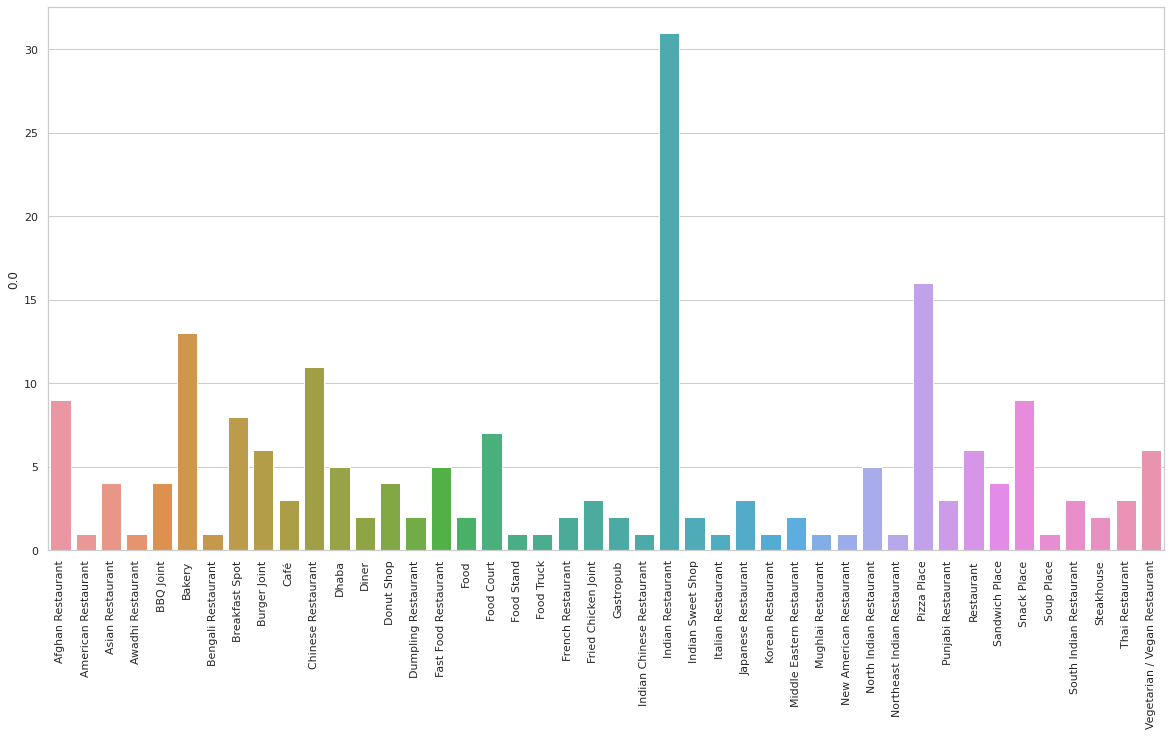

In [20]:
plot_bar(0)

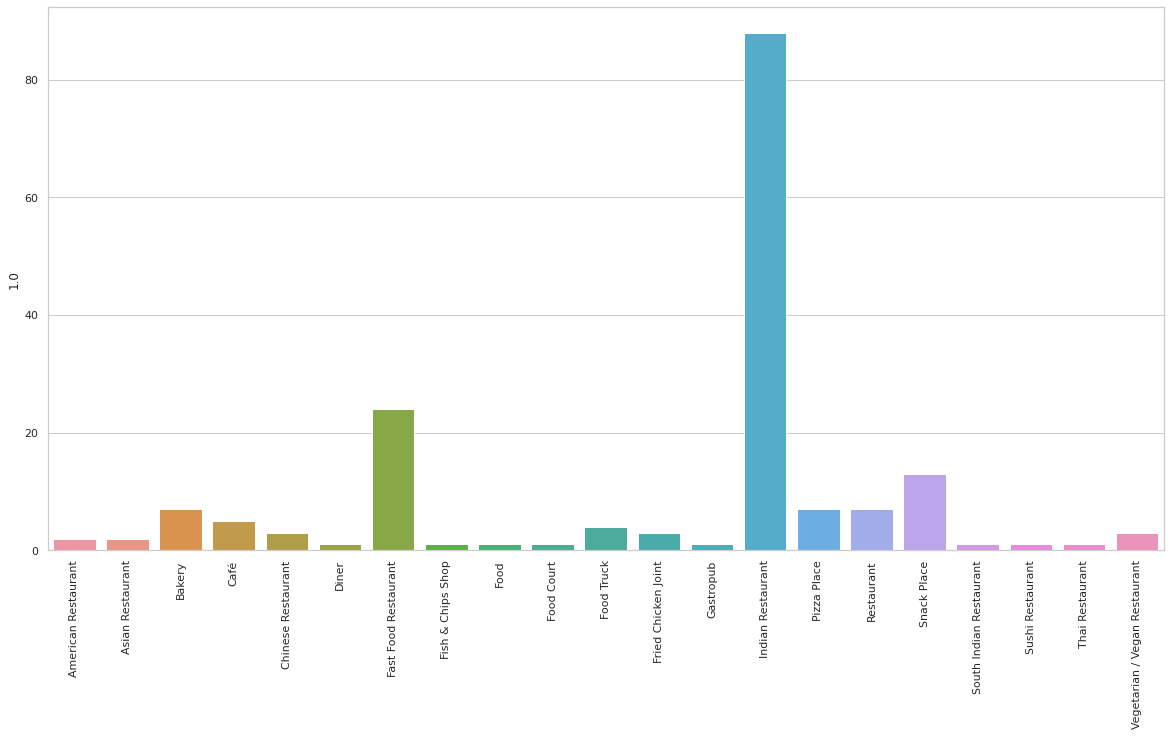

In [21]:
plot_bar(1)

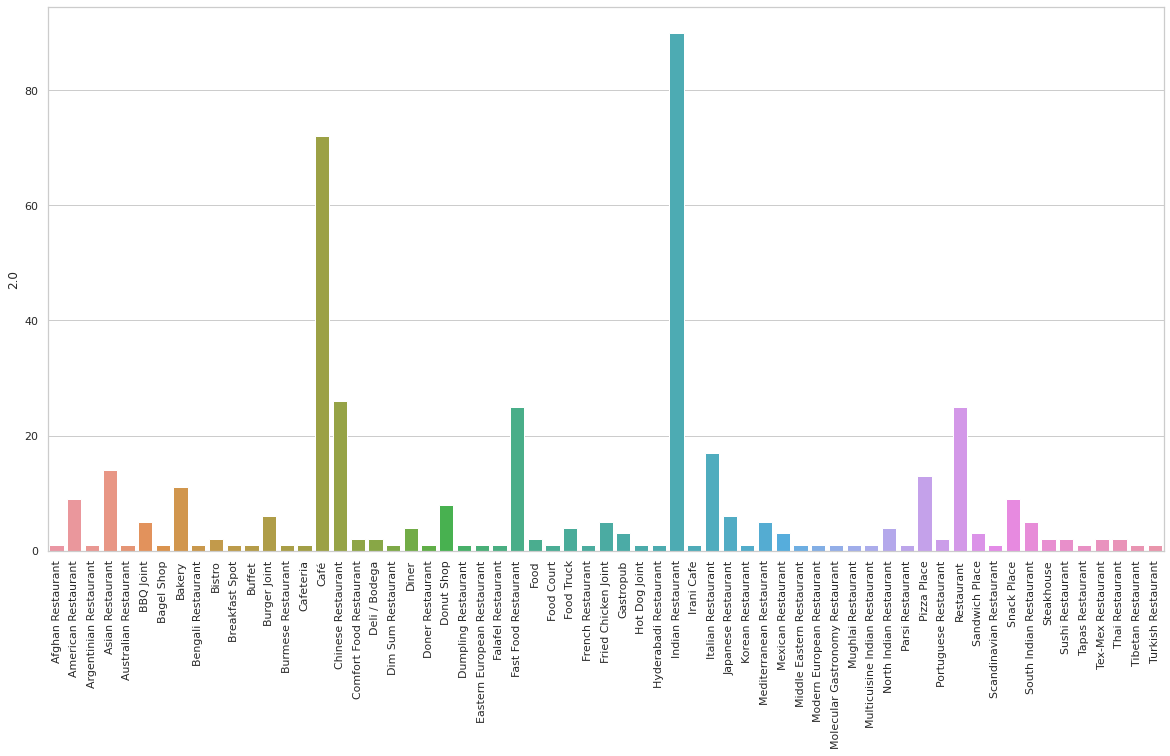

In [22]:
plot_bar(2)

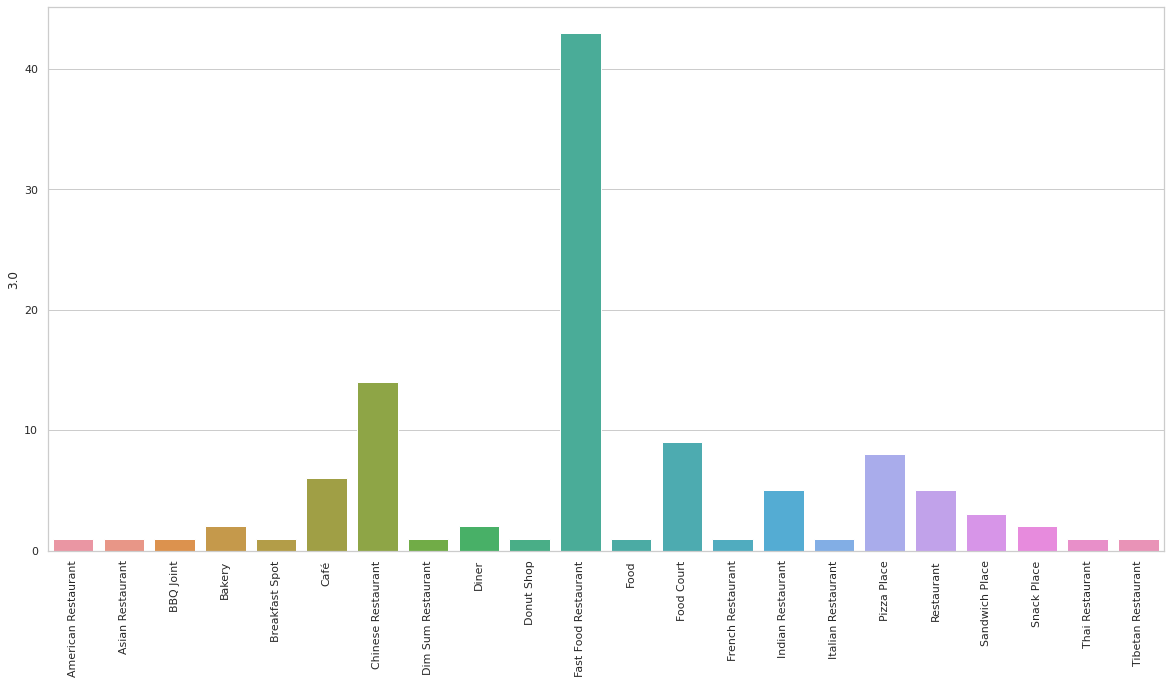

In [23]:
plot_bar(3)

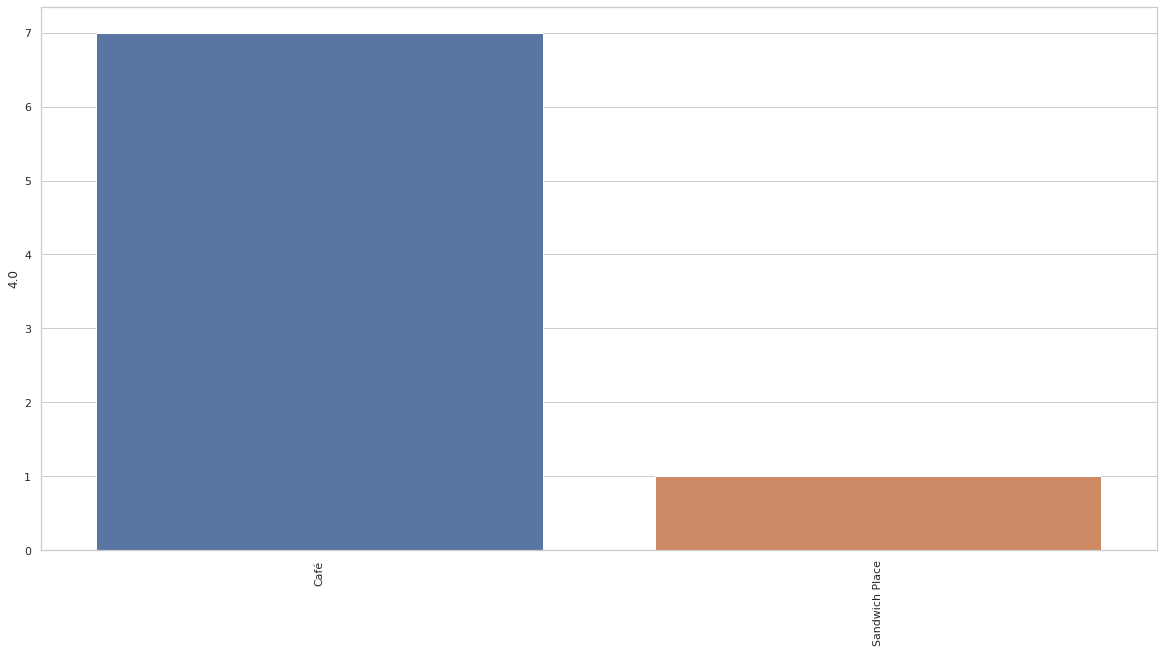

In [24]:
plot_bar(4)

Analysing the bar graphs we can clearly see that <b>clusters 1 and 2</b> have a high demand for Indian Restaurants

## Recommendation
<a name='recommendation'></a>

In [25]:
delhi_venues.drop('Unnamed: 0',axis=1,inplace=True)

In [26]:
forheatmap=delhi_venues.copy()
forheatmap=pd.merge(forheatmap,delhi_merged[['Neighborhood','Cluster Labels']],left_on='Neighborhood', right_on='Neighborhood',how='inner')
forheatmap.drop(forheatmap[~forheatmap['Cluster Labels'].isin([1,2])].index, inplace=True)

In [27]:
forheatmap.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
4,Ashok Vihar,28.699453,77.184826,Nat Khat Caterers,28.699630,77.187832,Indian Restaurant,1.0
5,Ashok Vihar,28.699453,77.184826,Bakers Stop,28.700495,77.188716,Bakery,1.0
6,Ashok Vihar,28.699453,77.184826,Invitation Banquet,28.696018,77.185953,Diner,1.0
7,Ashok Vihar,28.699453,77.184826,Gola Northend,28.701242,77.189288,Indian Restaurant,1.0
8,Azadpur,28.707657,77.175547,jungrele,28.705655,77.172069,Argentinian Restaurant,2.0


In [28]:
from folium.plugins import HeatMap

In [29]:
#heat map of all restaurants in selected Neighborhoods
res_heat = folium.Map(location=[latitude, longitude], zoom_start=11)
HeatMap(list(zip(forheatmap['Venue Latitude'],forheatmap['Venue Longitude'])),
        min_opacity=0.2,
        radius=10, blur=15,
        max_zoom=1
       ).add_to(res_heat)
for lat, lng, label in zip(forheatmap['Neighborhood Latitude'], forheatmap['Neighborhood Longitude'], forheatmap['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(res_heat)
res_heat

In [30]:
forindres = forheatmap[forheatmap['Venue Category']=='Indian Restaurant']

# heat map for Indian Restaurants in the selected Neighborhoods
res_heat_ind = folium.Map(location=[latitude, longitude], zoom_start=11)
HeatMap(list(zip(forindres['Venue Latitude'],forindres['Venue Longitude'])),
        min_opacity=0.2,
        radius=10, blur=15,
        max_zoom=1
       ).add_to(res_heat_ind)
for lat, lng, label in zip(forindres['Neighborhood Latitude'], forindres['Neighborhood Longitude'], forindres['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(res_heat_ind)
res_heat_ind

now we will remove all neighborhoods with the following conditions:
* Number of Indian restaurants >30%
* Number of all restaurants >60% 
<br>

'%' here refers to percentile

In [31]:
count_all = forheatmap[['Neighborhood','Venue']].groupby('Neighborhood').count().sort_values(by='Venue')
target_count = int(0.6*len(count_all))
print(count_all.iloc[target_count])
count_all.drop(count_all[count_all.Venue.values>7].index,inplace=True)
count_all.columns=['all count']
count_all.head()

Venue    6
Name: Karol Bagh, dtype: int64


,all count
Neighborhood,
Vivek Vihar,1
Roshanara Bagh,1
Pragati Maidan,1
Inderpuri,2
Paschim Vihar,2


In [32]:
count_ind = forheatmap[forheatmap['Venue Category']=="Indian Restaurant"][['Neighborhood','Venue']].groupby('Neighborhood').count().sort_values(by='Venue')
target_count = int(0.3*len(count_ind))
print(count_ind.iloc[target_count])
count_ind.drop(count_ind[count_ind.Venue.values>1].index,inplace=True)
count_ind.columns = ['ind count']
count_ind.head()

Venue    2
Name: Pandav Nagar, dtype: int64


,ind count
Neighborhood,
Vivek Vihar,1
Keshav Puram,1
Lajpat Nagar,1
Maharani Bagh,1
Mayur Vihar,1


In [33]:
lowdensity = count_all.join(count_ind)
lowdensity.index.values

array(['Vivek Vihar', 'Roshanara Bagh', 'Pragati Maidan', 'Inderpuri',
       'Paschim Vihar', 'New Friends Colony', 'Jor Bagh', 'Khanpur',
       'Kishangarh Village', 'Mayur Vihar', 'Jhilmil Colony',
       'Pandav Nagar', 'Naraina', 'Meera Bagh', 'Maharani Bagh',
       'Vikaspuri', 'Pitam Pura', 'Rangpuri', 'Rani Bagh', 'Netaji Nagar',
       'Neeti Bagh', 'Ashok Vihar', 'Lahori Gate', 'Azadpur', 'Jasola',
       'Daryaganj', 'Jhandewalan', 'Gulmohar Park', 'Sarvodaya Enclave',
       'Chawri Bazaar', 'Patparganj', 'Dilshad Garden', 'Keshav Puram',
       'Laxmi Nagar', 'Civil Lines', 'Janakpuri', 'Moti Nagar',
       'Karol Bagh', 'Hauz Khas', 'Mahipalpur', 'East of Kailash',
       'Shakarpur', 'Shahpur Jat'], dtype=object)

In [34]:
temp_recommend = delhiData.copy()
temp_recommend.drop(temp_recommend[~temp_recommend['Neighborhood'].isin(lowdensity.index.values)].index, inplace=True)
temp_recommend.head()

,Borough,Neighborhood,latitude,longitude
1,North West Delhi,Ashok Vihar,28.699453,77.184826
2,North West Delhi,Azadpur,28.707657,77.175547
7,North West Delhi,Keshav Puram,28.688926,77.161683
12,North West Delhi,Pitam Pura,28.703268,77.132250
13,North West Delhi,Rani Bagh,28.685982,77.132524


Now, we will add the last constraint i.e the neighborhood should be close to popular neighborhoods

In [35]:
#most popular neighborhoods
top_nei = delhi_venues[['Neighborhood','Venue']].groupby('Neighborhood').count().sort_values(by='Venue', ascending=False).head(3).index.values
top_nei

array(['Connaught Place', 'Khirki Village', 'Hauz Khas Village'],
      dtype=object)

In [36]:
toplatlng = delhiData[['Neighborhood','latitude','longitude']][delhiData['Neighborhood'].isin(top_nei)].reset_index()
toplatlng

,index,Neighborhood,latitude,longitude
0,58,Connaught Place,28.631383,77.219792
1,95,Hauz Khas Village,28.553855,77.194713
2,103,Khirki Village,28.529885,77.218077


In [37]:
from math import sin, cos, sqrt, atan2, radians

def distanceInKM(la1,lo1,la2,lo2):
    # approximate radius of earth in km
    R = 6373.0
    
    lat1 = radians(la1)
    lon1 = radians(lo1)
    lat2 = radians(la2)
    lon2 = radians(lo2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    dis = R * c
    return round(dis,4)

print("Result:", distanceInKM(toplatlng.iloc[2]['latitude'],toplatlng.iloc[2]['longitude'],toplatlng.iloc[0]['latitude'],toplatlng.iloc[0]['longitude']))

Result: 11.2908


In [38]:
temp_recommend.reset_index(inplace=True)

In [39]:
temp_recommend.drop(columns=['index','Borough'], inplace=True)

In [40]:
temp_recommend.head()

,Neighborhood,latitude,longitude
0,Ashok Vihar,28.699453,77.184826
1,Azadpur,28.707657,77.175547
2,Keshav Puram,28.688926,77.161683
3,Pitam Pura,28.703268,77.132250
4,Rani Bagh,28.685982,77.132524


In [41]:
for i in toplatlng.index:
    temp_recommend[toplatlng.iloc[i]['Neighborhood']] = temp_recommend.apply(lambda x : distanceInKM(toplatlng.iloc[i]['latitude'],toplatlng.iloc[i]['longitude'],x['latitude'],x['longitude']),axis=1)

In [42]:
temp_recommend.head()

,Neighborhood,latitude,longitude,Connaught Place,Hauz Khas Village,Khirki Village
0,Ashok Vihar,28.699453,77.184826,8.3050,16.2236,19.1385
1,Azadpur,28.707657,77.175547,9.5196,17.2094,20.2048
2,Keshav Puram,28.688926,77.161683,8.5518,15.3662,18.5274
3,Pitam Pura,28.703268,77.132250,11.7016,17.7027,21.0274
4,Rani Bagh,28.685982,77.132524,10.4610,15.9015,19.2680


In [43]:
# top 5 neighborhoods near Connaught Place
neiNearCP = temp_recommend.sort_values(by=['Connaught Place']).iloc[:,:3].head().set_index('Neighborhood')
neiNearCP

,latitude,longitude
Neighborhood,,
Chawri Bazaar,28.649927,77.229788
Pragati Maidan,28.623459,77.242512
Jhandewalan,28.644336,77.199927
Daryaganj,28.646090,77.243048
Lahori Gate,28.656841,77.218534


In [44]:
# top 5 neighborhoods near Hauz Khas Village
neiNearHK = temp_recommend.sort_values(by=['Hauz Khas Village']).iloc[:,:3].head().set_index('Neighborhood')
neiNearHK

,latitude,longitude
Neighborhood,,
Hauz Khas,28.544256,77.206707
Gulmohar Park,28.557101,77.213006
Sarvodaya Enclave,28.537478,77.202089
Shahpur Jat,28.548330,77.214104
Neeti Bagh,28.559251,77.216166


In [45]:
# top 5 neighborhoods near Khirki Village
neiNearKV = temp_recommend.sort_values(by=['Khirki Village']).iloc[:,:3].head().set_index('Neighborhood')
neiNearKV

,latitude,longitude
Neighborhood,,
Sarvodaya Enclave,28.537478,77.202089
Hauz Khas,28.544256,77.206707
Shahpur Jat,28.548330,77.214104
Khanpur,28.512798,77.232395
Gulmohar Park,28.557101,77.213006


In [46]:
final_recommend=neiNearCP.append(neiNearHK).append(neiNearKV).reset_index()
final_recommend.drop_duplicates(inplace=True)
final_recommend.reset_index(inplace=True)
final_recommend.drop(columns=['index'],inplace=True)
final_recommend

,Neighborhood,latitude,longitude
0,Chawri Bazaar,28.649927,77.229788
1,Pragati Maidan,28.623459,77.242512
2,Jhandewalan,28.644336,77.199927
3,Daryaganj,28.646090,77.243048
4,Lahori Gate,28.656841,77.218534
5,Hauz Khas,28.544256,77.206707
6,Gulmohar Park,28.557101,77.213006
7,Sarvodaya Enclave,28.537478,77.202089
8,Shahpur Jat,28.548330,77.214104
9,Neeti Bagh,28.559251,77.216166


## Final Recommendation

In [47]:
final = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(final_recommend['latitude'], final_recommend['longitude'], final_recommend['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(final)  
    
final